<a href="https://colab.research.google.com/github/Shujaat123/Noisy-AE-LSE/blob/main/Noisy_VariationalAutoencoder_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Noisy-VAE-LSE: Noisy bypass-Variational Autoencoder with Latent Space Encoding**

---



**Loading Useful libraries and packages**


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import random
!pip install wget
from random import sample

from os import path
import h5py
import keras.backend as K
import wget

from keras.utils.np_utils import to_categorical
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, AveragePooling2D, Dropout, Conv2DTranspose, SeparableConv2D, Add
from keras.models import Model
from keras import backend as K
from tensorflow.keras import datasets, layers, losses

**Loading dataset**

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

**Defining Sampling Layer for Variational AutoEncoder**

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1:]
        # epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim[0],dim[1],dim[2]))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

**Defining autoencoder(AE) model**

In [4]:
def my_model():
  input_img = Input(shape=(32, 32, 3))
  num_filter = 32
  kernel_size = 7
  strides = 2   
  activation='tanh'

  x = Conv2D(num_filter, kernel_size, 1, activation=activation, padding='same', name = 'enc1')(input_img)
  # x = AveragePooling2D((2, 2))(x)
  x = BatchNormalization()(x)
  x = Conv2D(num_filter, kernel_size, strides, activation=activation, padding='same', name = 'enc2')(x) 
  # x = AveragePooling2D((2, 2))(x)

  # x = Conv2D(3, kernel_size, strides, activation='relu', padding='same', name = 'enc4')(x) 
  # x = AveragePooling2D((2, 2))(x)

  # encoded = BatchNormalization()(Conv2D(3, 1, 1, activation=activation, padding='valid', name = 'encoder_output')(x))
  
  z_mean = BatchNormalization()(Conv2D(3, 1, 1, activation=activation, padding='valid', name = 'z_mean')(x))
  z_log_var = BatchNormalization()(Conv2D(3, 1, 1, activation=activation, padding='valid', name = 'z_log_var')(x))  
  encoded = Sampling()([z_mean, z_log_var])

  # z_mean = Dense(LV, name="z_mean")(enc_l3)
  # z_log_var = Dense(LV, name="z_log_var")(enc_l3)
  # encoded = Sampling()([z_mean, z_log_var])

  x = UpSampling2D((2,2), interpolation = 'bilinear')(encoded)
  x = Conv2DTranspose(num_filter, kernel_size, 1, activation=activation, padding='same', name = 'dec1')(x)

  # x = UpSampling2D((2,2), interpolation = 'bilinear')(x)
  # x = Conv2DTranspose(3, kernel_size, strides, activation=activation, padding='same', name = 'dec2')(x)
  x = BatchNormalization()(x)
  
  # x = UpSampling2D((2,2), interpolation = 'bilinear')(x)
  x = Conv2DTranspose(num_filter, kernel_size, 1, activation=activation, padding='same', name = 'dec2')(x)
  # x = BatchNormalization()(x)
  decoded = Conv2D(3, (1, 1), activation='sigmoid', name = 'output')(x)

  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
  return autoencoder

autoencoder = my_model()

In [5]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 enc1 (Conv2D)                  (None, 32, 32, 32)   4736        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['enc1[0][0]']                   
 alization)                                                                                       
                                                                                                  
 enc2 (Conv2D)                  (None, 16, 16, 32)   50208       ['batch_normalization[0][0]']

**Training autoencoder(AE) model**

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')

checkpoint = ModelCheckpoint('models\\model-best.h5',
                                  verbose=0, monitor='val_loss',save_best_only=True, mode='auto')

autoencoder.fit(train_images, train_images,
                epochs=200,
                batch_size=256,
                shuffle=True,
                validation_data=(test_images, test_images),
                callbacks = [es, checkpoint]
                )

del autoencoder  # deletes the existing model
autoencoder = load_model('models\\model-best.h5')

Epoch 1/200
 79/196 [===========>..................] - ETA: 14s - loss: 0.0227

**Testing autoencoder(AE) model**

In [ ]:
predicted_test = autoencoder.predict(test_images[:100])
predicted_test = np.clip(predicted_test, 0., 1.)

In [ ]:
n = 3
plt.figure(figsize=(6, 6))
for i in range(n):

    # display original + noise
    ax = plt.subplot(3, n, i + 1)
    plt.title("Label")
    plt.imshow(tf.squeeze((test_images[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(3, n, i + n + 1)
    plt.title("predicted")
    plt.imshow(tf.squeeze((predicted_test[i]*255).astype('uint8')))
 #   plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 2*n + 1)
    plt.title("Label - Predicted")
    residual = np.squeeze(np.abs(test_images[i] - predicted_test[i]))
    residual = residual/residual.max()
    plt.imshow((residual*255).astype('uint8')) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
psnr_pred = tf.image.psnr(predicted_test, test_images[:100], max_val=1.0)
print('PSNR: ', np.mean(psnr_pred))

**Analyzing Noise Characteristics of autoencoder(AE) model**

In [ ]:
noise_factor_uniform = 0.4
noise_factor_normal = 0.25
noise_factor_speckle = 1.2

x_test_noisy_uniform = test_images + noise_factor_uniform * np.random.uniform(size=test_images.shape) 
x_test_noisy_normal = test_images + noise_factor_normal * np.random.normal(size=test_images.shape)
x_test_noisy_speckle = test_images + noise_factor_speckle * test_images * np.random.uniform(size=test_images.shape)


x_test_noisy_uniform = np.clip(x_test_noisy_uniform, 0., 1.)
x_test_noisy_normal = np.clip(x_test_noisy_normal, 0., 1.)
x_test_noisy_speckle = np.clip(x_test_noisy_speckle, 0., 1.)

In [ ]:
predicted_uniform = autoencoder.predict(x_test_noisy_uniform[:100])
predicted_normal = autoencoder.predict(x_test_noisy_normal[:100])
predicted_speckle = autoencoder.predict(x_test_noisy_speckle[:100])

predicted_uniform = np.clip(predicted_uniform, 0., 1.)
predicted_normal = np.clip(predicted_normal, 0., 1.)
predicted_speckle = np.clip(predicted_speckle, 0., 1.)

In [ ]:
n = 3
plt.figure(figsize=(8, 12))
for i in range(n):

    # display original + noise
    ax = plt.subplot(5, n, i + 1)
    plt.title("Label")
    plt.imshow(tf.squeeze((test_images[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(5, n, i + n + 1)
    plt.title("Label + Uniform Noise")
    plt.imshow(tf.squeeze((x_test_noisy_uniform[i]*255).astype('uint8')))
 #   plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 2*n + 1)
    plt.title("Label - Input")
    residual_input = np.squeeze(np.abs(test_images[i] - x_test_noisy_uniform[i]))
    residual_input = residual_input/residual_input.max()
    plt.imshow((residual_input*255).astype('uint8')) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 3*n + 1)
    plt.title("Predicted")
    plt.imshow(tf.squeeze((predicted_uniform[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 4*n + 1)
    plt.title("Label - Predicted")
    residual = np.squeeze(np.abs(test_images[i] - predicted_uniform[i]))
    residual = residual/residual.max()
    plt.imshow((residual*255).astype('uint8'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
n = 3
plt.figure(figsize=(8, 12))
for i in range(n):

    # display original + noise
    ax = plt.subplot(5, n, i + 1)
    plt.title("Label")
    plt.imshow(tf.squeeze((test_images[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(5, n, i + n + 1)
    plt.title("Label + Gaussian Noise")
    plt.imshow(tf.squeeze((x_test_noisy_normal[i]*255).astype('uint8')))
 #   plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 2*n + 1)
    plt.title("Label - Input")
    residual_input = np.squeeze(np.abs(test_images[i] - x_test_noisy_normal[i]))
    residual_input = residual_input/residual_input.max()
    plt.imshow((residual_input*255).astype('uint8')) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 3*n + 1)
    plt.title("Predicted")
    plt.imshow(tf.squeeze((predicted_normal[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 4*n + 1)
    plt.title("Label - Predicted")
    residual = np.squeeze(np.abs(test_images[i] - predicted_normal[i]))
    residual = residual/residual.max()
    plt.imshow((residual*255).astype('uint8'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
n = 3
plt.figure(figsize=(8, 12))
for i in range(n):

    # display original + noise
    ax = plt.subplot(5, n, i + 1)
    plt.title("Label")
    plt.imshow(tf.squeeze((test_images[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(5, n, i + n + 1)
    plt.title("Label + Speckle Noise")
    plt.imshow(tf.squeeze((x_test_noisy_speckle[i]*255).astype('uint8')))
 #   plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 2*n + 1)
    plt.title("Label - Input")
    residual_input = np.squeeze(np.abs(test_images[i] - x_test_noisy_speckle[i]))
    residual_input = residual_input/residual_input.max()
    plt.imshow((residual_input*255).astype('uint8')) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 3*n + 1)
    plt.title("Predicted")
    plt.imshow(tf.squeeze((predicted_speckle[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 4*n + 1)
    plt.title("Label - Predicted")
    residual = np.squeeze(np.abs(test_images[i] - predicted_speckle[i]))
    residual = residual/residual.max()
    plt.imshow((residual*255).astype('uint8'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
psnr_uniform_pred = tf.image.psnr(predicted_uniform, test_images[:100], max_val=1.0)
psnr_uniform_input = tf.image.psnr(x_test_noisy_uniform[:100], test_images[:100], max_val=1.0)

psnr_normal_pred = tf.image.psnr(predicted_normal, test_images[:100], max_val=1.0)
psnr_normal_input = tf.image.psnr(x_test_noisy_normal[:100], test_images[:100], max_val=1.0)

psnr_speckle_pred = tf.image.psnr(predicted_speckle, test_images[:100], max_val=1.0)
psnr_speckle_input = tf.image.psnr(x_test_noisy_speckle[:100], test_images[:100], max_val=1.0)

print('Uniform: ', np.mean(psnr_uniform_input), np.mean(psnr_uniform_pred))
print('Gaussian: ', np.mean(psnr_normal_input), np.mean(psnr_normal_pred))
print('Speckle: ', np.mean(psnr_speckle_input), np.mean(psnr_speckle_pred))

**Calculating Statistics for Noise Characteristics Curve of autoencoder(AE) model**

In [ ]:
def calculate_PSNR(test_images,noise_factor_uniform,noise_factor_normal,noise_factor_speckle,autoencoder):
  x_test_noisy_uniform = test_images + noise_factor_uniform * np.random.uniform(size=test_images.shape) 
  x_test_noisy_normal = test_images + noise_factor_normal * np.random.normal(size=test_images.shape)
  x_test_noisy_speckle = test_images + noise_factor_speckle * test_images * np.random.uniform(size=test_images.shape)


  x_test_noisy_uniform = np.clip(x_test_noisy_uniform, 0., 1.)
  x_test_noisy_normal = np.clip(x_test_noisy_normal, 0., 1.)
  x_test_noisy_speckle = np.clip(x_test_noisy_speckle, 0., 1.)

  predicted_uniform = autoencoder.predict(x_test_noisy_uniform[:100])
  predicted_normal = autoencoder.predict(x_test_noisy_normal[:100])
  predicted_speckle = autoencoder.predict(x_test_noisy_speckle[:100])

  predicted_uniform = np.clip(predicted_uniform, 0., 1.)
  predicted_normal = np.clip(predicted_normal, 0., 1.)
  predicted_speckle = np.clip(predicted_speckle, 0., 1.)

  psnr_uniform_pred = tf.image.psnr(predicted_uniform, test_images[:100], max_val=1.0)
  psnr_uniform_input = tf.image.psnr(x_test_noisy_uniform[:100], test_images[:100], max_val=1.0)

  psnr_normal_pred = tf.image.psnr(predicted_normal, test_images[:100], max_val=1.0)
  psnr_normal_input = tf.image.psnr(x_test_noisy_normal[:100], test_images[:100], max_val=1.0)

  psnr_speckle_pred = tf.image.psnr(predicted_speckle, test_images[:100], max_val=1.0)
  psnr_speckle_input = tf.image.psnr(x_test_noisy_speckle[:100], test_images[:100], max_val=1.0)

  print('Uniform: ', np.mean(psnr_uniform_input), np.mean(psnr_uniform_pred))
  print('Gaussian: ', np.mean(psnr_normal_input), np.mean(psnr_normal_pred))
  print('Speckle: ', np.mean(psnr_speckle_input), np.mean(psnr_speckle_pred))

  return np.mean(psnr_uniform_input), np.mean(psnr_uniform_pred), np.mean(psnr_normal_input), np.mean(psnr_normal_pred), np.mean(psnr_speckle_input), np.mean(psnr_speckle_pred)

In [ ]:
# print('----')
# noise_factor_uniform = 0.74
# noise_factor_normal = 0.5
# noise_factor_speckle = 2.8
# calculate_PSNR(test_images,noise_factor_uniform,noise_factor_normal,noise_factor_speckle,autoencoder)
PSNR_Results = []
for i in range(0,20):
  noise_factor_uniform = i*0.04
  noise_factor_normal = i*0.025
  noise_factor_speckle = i*0.12
  PSNR_Results.append(calculate_PSNR(test_images,noise_factor_uniform,noise_factor_normal,noise_factor_speckle,autoencoder))
  print('----')

PSNR_Results = np.asarray(PSNR_Results)

In [ ]:
from scipy.io import savemat

savemat('Noisy_AE_PSNR_Results.mat',{'PSNR_Results':PSNR_Results})

from google.colab import files
files.download("Noisy_AE_PSNR_Results.mat")

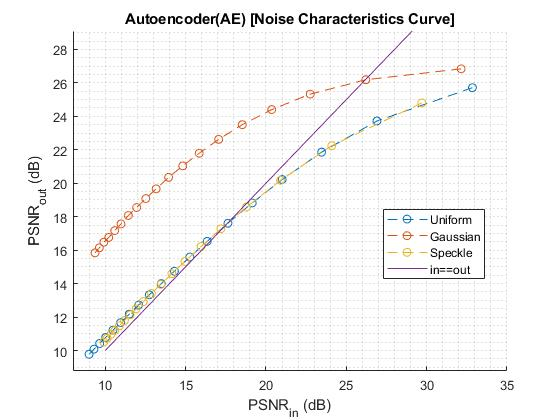

**AE-NCC for 16x16x3 (4x compression)**


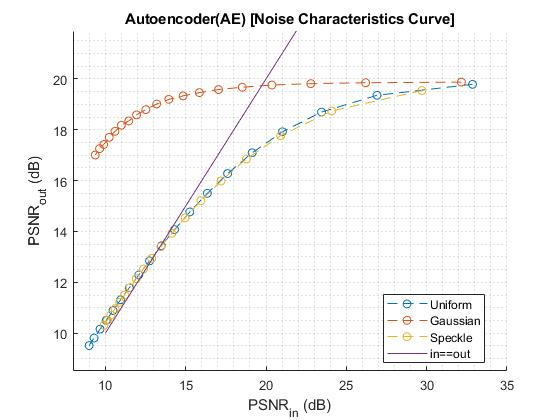

**AE-NCC for 8x8x3 (16x compression)**